In [233]:
import pandas as pd
pd.set_option('display.max_rows', 400)
import sys
sys.path.append("../")
from utils import createXYPlot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from functools import partial

import numpy as np
np.random.seed(111)

In [234]:
def get_lower_upper(x):
    if "+" not in x:
        lower = int(x.split("-")[0])
        upper = int(x.split("-")[1])
    else:
        lower = int(x.split("+")[0])
        upper = int(1e6)
    return lower,upper

In [235]:
def impute_val(x, high_val):
    if "<" in str(x):
        return int(np.random.uniform(low=1, high=high_val))
    else:
        return int(float(x))

In [236]:
df = pd.read_csv("./data/event-among-vaccinated-126.csv")
df = df.fillna(0)
df["date_0"] = df["Week"].apply(lambda x: x.split(" - ")[0])
df["date_1"] = df["Week"].apply(lambda x: x.split(" - ")[1])
df = df.rename(columns={"Age_group":"age_group"})

In [237]:
event_cols = [x for x in df.columns if "event_" in x]
for ev in event_cols:
    df[ev] = df[ev].apply(partial(impute_val, high_val=5))

In [238]:
df

,Week,age_group,Type_of_event,event_after_1st_dose,event_after_2nd_dose,event_after_3rd_dose,event_for_not_vaccinated,date_0,date_1
0,2020-12-20 - 2020-12-26,0-19,Hospitalization,0,0,0,57,2020-12-20,2020-12-26
1,2020-12-20 - 2020-12-26,0-19,Death,0,0,0,0,2020-12-20,2020-12-26
2,2020-12-20 - 2020-12-26,20-29,Hospitalization,0,0,0,52,2020-12-20,2020-12-26
3,2020-12-20 - 2020-12-26,20-29,Death,0,0,0,3,2020-12-20,2020-12-26
4,2020-12-20 - 2020-12-26,30-39,Hospitalization,0,0,0,80,2020-12-20,2020-12-26
...,...,...,...,...,...,...,...,...,...
1003,2022-01-09 - 2022-01-15,70-79,Death,4,3,11,1,2022-01-09,2022-01-15
1004,2022-01-09 - 2022-01-15,80-89,Hospitalization,10,41,216,72,2022-01-09,2022-01-15
1005,2022-01-09 - 2022-01-15,80-89,Death,1,2,5,7,2022-01-09,2022-01-15
1006,2022-01-09 - 2022-01-15,90+,Hospitalization,6,16,78,33,2022-01-09,2022-01-15


In [239]:
df_agg = df.groupby(["date_0","Type_of_event"]).agg(first_dose=("event_after_1st_dose","sum"),
                            second_dose=("event_after_2nd_dose","sum"),
                            third_dose=("event_after_3rd_dose","sum"),
                            no_vax=("event_for_not_vaccinated","sum")
                           ).reset_index()

In [240]:
df_agg["frac_no_vax"] = 100*df_agg["no_vax"]/(df_agg["first_dose"] + df_agg["second_dose"] + df_agg["third_dose"] + df_agg["no_vax"])

In [241]:
df_agg[df_agg.Type_of_event=="Hospitalization"].tail(5)

,date_0,Type_of_event,first_dose,second_dose,third_dose,no_vax,frac_no_vax
103,2021-12-12,Hospitalization,12,24,28,45,41.284404
105,2021-12-19,Hospitalization,6,22,39,78,53.793103
107,2021-12-26,Hospitalization,21,50,129,117,36.908517
109,2022-01-02,Hospitalization,44,144,384,291,33.719583
111,2022-01-09,Hospitalization,110,312,880,718,35.544554


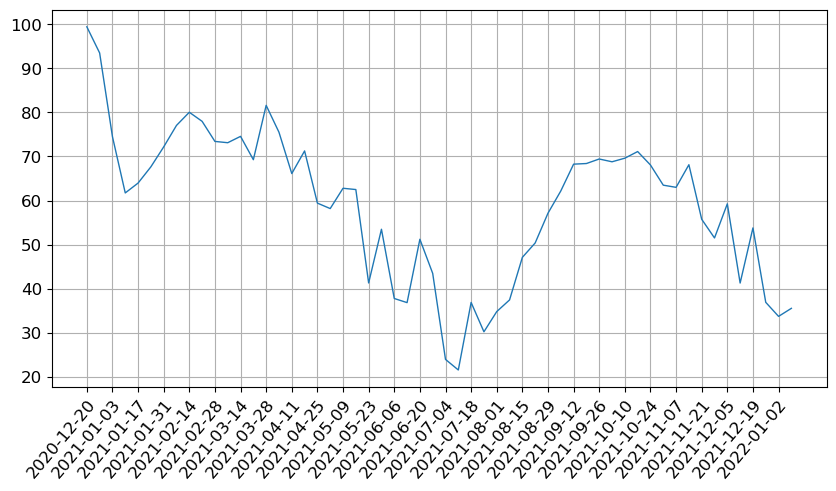

In [242]:
createXYPlot(df_agg[df_agg.Type_of_event=="Hospitalization"],
             y="frac_no_vax",
             x="date_0",
             plots_folder=None,
             days_interval=2
            )

### Population

In [243]:
df_pop = pd.read_csv("./data/Israel-population-2019.csv",header=0)
df_pop["tot"] = df_pop.M + df_pop.F

In [244]:
age_map = {}
for i in df_pop.Age.unique():
    initial = get_lower_upper(i)
    for j in df.age_group.unique():
        final = get_lower_upper(j)
        if initial[1] <= final[1]:
            age_map[i] = j
            break

In [245]:
df_pop["age_group"] = df_pop["Age"].map(age_map)
df_pop = df_pop.groupby("age_group").agg(pop=("tot","sum")).reset_index()

In [246]:
df = df.merge(df_pop, on="age_group", how="inner")

In [247]:
df_vax = pd.read_csv("./data/vaccinated-per-day-2022-02-01.csv")
for col in [c for c in df_vax.columns if "dose" in c]:
    print(col)
    df_vax[col] = df_vax[col].apply(partial(impute_val,high_val=15))
    df_vax[f"tot_{col}"] = df_vax.groupby(["age_group"])[col].cumsum()
df_vax["date_0"] = df_vax["VaccinationDate"]

df = df.merge(df_vax, on=["date_0", "age_group"], how="left")

first_dose
second_dose
third_dose
fourth_dose


In [248]:
df[df.date_0=="2022-01-09"][["date_0","Type_of_event","age_group","pop","tot_first_dose","tot_second_dose"]]

,date_0,Type_of_event,age_group,pop,tot_first_dose,tot_second_dose
110,2022-01-09,Hospitalization,0-19,3032351,1206003,906903
111,2022-01-09,Death,0-19,3032351,1206003,906903
222,2022-01-09,Hospitalization,20-29,1178880,1125217,1006622
223,2022-01-09,Death,20-29,1178880,1125217,1006622
334,2022-01-09,Hospitalization,30-39,1117905,1070787,982574
335,2022-01-09,Death,30-39,1117905,1070787,982574
446,2022-01-09,Hospitalization,40-49,1019070,1002925,933820
447,2022-01-09,Death,40-49,1019070,1002925,933820
558,2022-01-09,Hospitalization,50-59,779142,794982,750566
559,2022-01-09,Death,50-59,779142,794982,750566
